# Phylogic Reviewer

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from JupyterReviewer.Reviewers.PhylogicReviewer import PhylogicReviewer

import pandas as pd
from dash import html

## Edit the code below according to the commented directions

In [9]:
participant_df = pd.read_csv(f'../../example_notebooks/example_data/participant_75.tsv', sep='\t', index_col='entity:participant_id')
sample_df = pd.read_csv('../../example_notebooks/example_data/pairs_75.tsv', sep='\t', index_col='Sample_ID')


In [11]:
reviewer = PhylogicReviewer()

reviewer.set_review_data(
    # Enter the file path where you would like your pkl file of your review data to be stored
    data_pkl_fn='../test_Phylogic_Reviewer_test14.pkl',
    # Breifly describe the source of your data and its purpose
    description='Test phylogic review',
    # Enter the file path to your data to be reviewed
    participant_df=participant_df,
    sample_df=sample_df,
    preprocess_data_dir='../../example_notebooks/example_data/test_preprocess/',

)

reviewer.set_review_app(preprocess_data_dir='../../example_notebooks/example_data/test_preprocess/', drivers_fn='../../example_notebooks/example_data/drivers.txt')
reviewer.set_default_review_data_annotations_configuration()

cnv figs directory already exists: ../../example_notebooks/example_data/test_preprocess/cnv_figs


/Users/cmesser/PycharmProjects/reviewer_tools/JupyterReviewer/JupyterReviewer/ReviewData.py:38: UserWarning:

Loading existing data pkl file



In [ ]:
import inspect
type(reviewer).gen_review_app.__doc__

In [ ]:
def make_docstring(object_type_name, func1_doc, func2):
    func2_doc = f"{object_type_name}.{func2.__name__}" + str(inspect.signature(func2)) + func2.__doc__
    if func2_doc not in func1_doc:
        return func1_doc + func2_doc
    else:
        return func1_doc
    
make_docstring(object_type_name=type(reviewer).__name__,
                           func1_doc=type(reviewer).set_review_app.__doc__,
                           func2=type(reviewer).gen_review_app)

In [13]:
def make_docstring(object_type_name, func1_doc, func2):
    func2_doc = f"{object_type_name}.{func2.__name__}" + str(inspect.signature(func2)) + func2.__doc__
    if func2_doc not in func1_doc:
        return func1_doc + func2_doc
    else:
        return func1_doc
    
make_docstring(object_type_name=type(reviewer).__name__,
                           func1_doc=type(reviewer).set_review_app.__doc__,
                           func2=type(reviewer).gen_review_app)

TypeError: can only concatenate str (not "NoneType") to str

## Run

In [89]:
reviewer.run(mode='external', port=8088)

Dash app running on http://0.0.0.0:8088/


In [ ]:
sample_data_df=pd.read_csv('/Users/cmesser/Documents/Projects/participant_reviewer/pairs_75.tsv', sep='\t').set_index('entity:pair_id')
data_df = pd.read_csv(f'/Users/cmesser/Documents/Projects/participant_reviewer/participant_75.tsv', sep='\t').set_index('entity:participant_id')
from cnv_suite import switch_contigs
mut_ccfs_df = switch_contigs(pd.read_csv(data_df.loc['GBM.ICB-75']['mut_ccfs'], sep='\t'))
mut_ccfs_df['Chromosome'] = mut_ccfs_df['Chromosome'].astype(int)  # todo change
seg_df = []
for sample_id in sample_data_df.sort_values('collection_date_dfd').index.tolist():
    this_seg_df = pd.read_csv(sample_data_df.loc[sample_id, 'alleliccapseg_tsv'], sep='\t')
    this_seg_df['Sample_ID'] = sample_id
    seg_df.append(this_seg_df)
seg_trees = cnv_suite.get_segment_interval_trees(pd.concat(seg_df))

In [ ]:
tup = seg_trees[22][10000000].pop().data['GBM.ICB-75-19.778.A1-Post3']

In [ ]:
mut_ccfs_df = cnv_suite.apply_segment_data_to_df(mut_ccfs_df, seg_trees)

In [ ]:
seg_df = []
for sample_id in sample_data_df.sort_values('collection_date_dfd').index.tolist():
    this_seg_df = pd.read_csv(sample_data_df.loc[sample_id, 'alleliccapseg_tsv'], sep='\t')
    this_seg_df['Sample_ID'] = sample_id
    seg_df.append(this_seg_df)

In [ ]:
import cnv_suite
seg_trees = cnv_suite.get_segment_interval_trees(pd.concat(seg_df))

In [ ]:
seg_trees[22][10000000].pop().data['GBM.ICB-75-19.778.A1-Post3_pair']

In [ ]:
pd.concat(seg_df.values())

### Test plotting

In [3]:
#from PhylogicReviewer import ccf_pmf_plot
import pandas as pd
import re
import plotly.express as px

df = pd.DataFrame([['ONC106612', 'gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/1dc35867-4c57-487e-bcdd-e39820462211/phylogicndt/b007b77f-c150-490f-9d55-7ace9eb495dd/call-clustering/ONC106612.mut_ccfs.txt'], ['ONC110293', 'gs://fc-secure-c1d8f0c8-dc8c-418a-ac13-561b18de3d8e/1dc35867-4c57-487e-bcdd-e39820462211/phylogicndt/598b3916-a3b8-49dd-a3cb-bfb8ab8cd08e/call-clustering/cacheCopy/ONC110293.mut_ccfs.txt']], columns=['participant_id', 'mut_ccfs'])
df.set_index('participant_id', inplace=True)
mut_ids = ['13:67799823C>A', '3:99568657T>C', '17:1558752G>A']
samples = ['17318_13_OCT_052219', '17318_13_BB_111119']


In [4]:
def ccf_pmf_plot(data_df, idx, mut_ids, sample_selection, group_clusters=False):
    """Plots the CCF pmf distribution for the chosen mutation(s).

    Notes
    -----
    - Displays the pmf distribution as a normalized histogram
    - Samples are shown in separate rows
    - Clusters displayed with different colors, with adjacent bars
    
    TODO
    ----
    - Add a star (*) above the mode for each mutation
    - Add an indication of mean?

    """
    mut_ccfs_df = pd.read_csv(data_df.loc[idx, 'mut_ccfs'], sep='\t')
    mut_ccfs_df['unique_mut_id'] = mut_ccfs_df.apply(get_unique_identifier, axis=1)
    chosen_muts_df = mut_ccfs_df[mut_ccfs_df['unique_mut_id'].isin(mut_ids)].copy()

    ccfs_headers = [re.search('.*[01].[0-9]+', i) for i in mut_ccfs_df.columns]
    ccfs_headers = [x.group() for x in ccfs_headers if x]
    ccfs_header_dict = {i: re.search('[01].[0-9]+', i).group() for i in ccfs_headers}

    #pmf_plot = make_subplots(1, len(sample_selection))
    stacked_muts = chosen_muts_df.set_index(['Sample_ID', 'unique_mut_id', 'Cluster_Assignment'])[
        ccfs_headers].stack().reset_index().rename(columns={'level_3': 'CCF', 0: 'Probability'}).replace(ccfs_header_dict)
    if group_clusters:
        stacked_muts['Cluster_Assignment'] = stacked_muts['Cluster_Assignment'].astype(str)
        fig = px.histogram(stacked_muts, x='CCF', y='Probability', facet_row='Sample_ID', barmode='group', height=300*len(sample_selection), color='Cluster_Assignment', histfunc='avg', color_discrete_map=get_phylogic_color_scale())
    else:
        fig = px.histogram(stacked_muts, x='CCF', y='Probability', facet_row='Sample_ID', barmode='group', height=300*len(sample_selection), color='unique_mut_id', labels={'unique_mut_id': 'Mutation'})
        mut_label_dict = {x['unique_mut_id']: f"{x['Hugo_Symbol']} - {x['Chromosome']}:{x['Start_position']}" for idx, x in chosen_muts_df.drop_duplicates('unique_mut_id').iterrows()}
        fig.for_each_trace(lambda t: t.update(name = mut_label_dict[t.name]))

    fig.update_layout(xaxis_tickangle=0, xaxis_ticklabelstep=5)
    fig.update_yaxes(matches=None)
    
    return fig


def get_unique_identifier(row, chrom='Chromosome', start_pos='Start_position',
                          ref='Reference_Allele', alt='Tumor_Seq_Allele'):
    """Generates unique string for this mutation, including contig, start position, ref and alt alleles.

    Does not include End Position, for this field is not present in mut_ccfs Phylogic output. However, specification of both the alt and ref alleles are enough to distinguish InDels.

    :param row: pd.Series giving the data for one mutation from a maf or maf-like dataframe
    :param chrom: the name of the contig/chromosome column/field; default: Chromosome
    :param start_pos: the name of the start position column/field; default: Start_position
    :param ref: the name of the reference allele column/field; default: Reference_Allele
    :param alt: the name of the alternate allele column/field; default: Tumor_Seq_Allele
    """
    return f"{row[chrom]}:{row[start_pos]}{row[ref]}>{row[alt]}"

In [ ]:
fig = ccf_pmf_plot(df, 'ONC106612', mut_ids, samples)

In [ ]:
fig.show()

In [ ]:
fig.update_yaxes(matches=None)

In [ ]:
mut_ccfs_df = pd.read_csv(df.loc['ONC106612', 'mut_ccfs'], sep='\t')
mut_ccfs_df['unique_mut_id'] = mut_ccfs_df.apply(get_unique_identifier, axis=1)
chosen_muts_df = mut_ccfs_df[mut_ccfs_df['unique_mut_id'].isin(mut_ids)].copy()

In [ ]:
chosen_muts_df.drop_duplicates('unique_mut_id').iteritems()

In [ ]:
mut_label_dict = {x['unique_mut_id']: f"{x['Hugo_Symbol']} - {x['Chromosome']}:{x['Start_position']}" for idx, x in chosen_muts_df.drop_duplicates('unique_mut_id').iterrows()}


In [ ]:
mut_label_dict

In [ ]:
mut_ccfs_df = pd.read_csv(df.loc['ONC106612', 'mut_ccfs'], sep='\t')
mut_ccfs_df['unique_mut_id'] = mut_ccfs_df.apply(get_unique_identifier, axis=1)
chosen_muts_df = mut_ccfs_df[mut_ccfs_df['unique_mut_id'].isin(mut_ids)].copy()

In [ ]:
chosen_muts_df.drop_duplicates('unique_mut_id').iteritems()

In [ ]:
mut_label_dict = {x['unique_mut_id']: f"{x['Hugo_Symbol']} - {x['Chromosome']}:{x['Start_position']}" for idx, x in chosen_muts_df.drop_duplicates('unique_mut_id').iterrows()}


In [ ]:
mut_label_dict

In [ ]:
def get_phylogic_color_scale():
    phylogic_color_list = [[166, 17, 129],
                           [39, 140, 24],
                           [103, 200, 243],
                           [248, 139, 16],
                           [16, 49, 41],
                           [93, 119, 254],
                           [152, 22, 26],
                           [104, 236, 172],
                           [249, 142, 135],
                           [55, 18, 48],
                           [83, 82, 22],
                           [247, 36, 36],
                           [0, 79, 114],
                           [243, 65, 132],
                           [60, 185, 179],
                           [185, 177, 243],
                           [139, 34, 67],
                           [178, 41, 186],
                           [58, 146, 231],
                           [130, 159, 21],
                           [161, 91, 243],
                           [131, 61, 17],
                           [248, 75, 81],
                           [32, 75, 32],
                           [45, 109, 116],
                           [255, 169, 199],
                           [55, 179, 113],
                           [34, 42, 3],
                           [56, 121, 166],
                           [172, 60, 15],
                           [115, 76, 204],
                           [21, 61, 73],
                           [67, 21, 74],  # Additional colors, uglier and bad
                           [123, 88, 112],
                           [87, 106, 46],
                           [37, 66, 58],
                           [132, 79, 62],
                           [71, 58, 32],
                           [59, 104, 114],
                           [46, 107, 90],
                           [84, 68, 73],
                           [90, 97, 124],
                           [121, 66, 76],
                           [104, 93, 48],
                           [49, 67, 82],
                           [71, 95, 65],
                           [127, 85, 44],  # even more additional colors, gray
                           [88, 79, 92],
                           [220, 212, 194],
                           [35, 34, 36],
                           [200, 220, 224],
                           [73, 81, 69],
                           [224, 199, 206],
                           [120, 127, 113],
                           [142, 148, 166],
                           [153, 167, 156],
                           [162, 139, 145],
                           [0, 0, 0]]  # black
    colors_dict = {str(i): get_hex_string(c) for i, c in enumerate(phylogic_color_list)}
    return colors_dict


def get_hex_string(c):
    return '#{:02X}{:02X}{:02X}'.format(*c)

In [ ]:
from JupyterReviewer.AppComponents.utils import get_unique_identifier
from cnv_suite import switch_contigs, get_segment_interval_trees, apply_segment_data_to_df

idx = 'GBM.ICB-75'
sample_selection = []
samples_df = sample_df.copy()

maf_df = pd.read_csv(participant_df.loc[idx, 'maf_fn'], sep='\t')
start_pos = maf_df.columns[maf_df.columns.isin(['Start_position', 'Start_Position'])][0]
alt = maf_df.columns[maf_df.columns.isin(['Tumor_Seq_Allele2', 'Tumor_Seq_Allele'])][0]
maf_df['id'] = maf_df.apply(lambda x: get_unique_identifier(x, start_pos=start_pos, alt=alt), axis=1)
maf_df.set_index('id', inplace=True, drop=False)

# if selected_mutation_rows:
#     maf_df = maf_df.loc[selected_mutation_rows]
# elif filtered_mutation_rows:
#     maf_df = maf_df.loc[filtered_mutation_rows]
# else (if all mutations in table are filtered out and none selected): use all mutations

sample_list = samples_df[samples_df['participant_id'] == idx].index.tolist()
# restrict sample selection to only two samples at a time
sample_selection_corrected = [sample_list[0]] if sample_selection == [] else sample_selection[:2]

# sigmas_val = 'Show CNV Sigmas' in sigmas

# if color == 'Differential':
#     segment_colors = 'difference'
# elif color == 'Cluster':
#     segment_colors = 'cluster'
# # unsure about clonal/subclonal
# else:
#     segment_colors = color

seg_df = []
for sample_id in sample_list:
    this_seg_df = pd.read_csv(samples_df.loc[sample_id, 'cnv_seg_fn'], sep='\t')
    this_seg_df['Sample_ID'] = sample_id
    seg_df.append(this_seg_df)

maf_df = maf_df[maf_df.Sample_ID.isin(sample_list)]
maf_df = switch_contigs(maf_df)
maf_df['Chromosome'] = maf_df['Chromosome'].astype(int)

seg_trees = get_segment_interval_trees(pd.concat(seg_df))
maf_df = apply_segment_data_to_df(maf_df, seg_trees)

In [ ]:
import importlib
import cnv_suite
importlib.reload(cnv_suite)

In [35]:
from JupyterReviewer.AppComponents.utils import get_unique_identifier
from cnv_suite import switch_contigs, get_segment_interval_trees, apply_segment_data_to_df

idx = 'GBM.ICB-75'
sample_selection = []
samples_df = sample_df.copy()

maf_df = pd.read_csv(participant_df.loc[idx, 'maf_fn'], sep='\t')
start_pos = maf_df.columns[maf_df.columns.isin(['Start_position', 'Start_Position'])][0]
alt = maf_df.columns[maf_df.columns.isin(['Tumor_Seq_Allele2', 'Tumor_Seq_Allele'])][0]
maf_df['id'] = maf_df.apply(lambda x: get_unique_identifier(x, start_pos=start_pos, alt=alt), axis=1)
maf_df.set_index('id', inplace=True, drop=False)

# if selected_mutation_rows:
#     maf_df = maf_df.loc[selected_mutation_rows]
# elif filtered_mutation_rows:
#     maf_df = maf_df.loc[filtered_mutation_rows]
# else (if all mutations in table are filtered out and none selected): use all mutations

sample_list = samples_df[samples_df['participant_id'] == idx].index.tolist()
# restrict sample selection to only two samples at a time
sample_selection_corrected = [sample_list[0]] if sample_selection == [] else sample_selection[:2]

# sigmas_val = 'Show CNV Sigmas' in sigmas

# if color == 'Differential':
#     segment_colors = 'difference'
# elif color == 'Cluster':
#     segment_colors = 'cluster'
# # unsure about clonal/subclonal
# else:
#     segment_colors = color

seg_df = []
for sample_id in sample_list:
    this_seg_df = pd.read_csv(samples_df.loc[sample_id, 'cnv_seg_fn'], sep='\t')
    this_seg_df['Sample_ID'] = sample_id
    seg_df.append(this_seg_df)

maf_df = maf_df[maf_df.Sample_ID.isin(sample_list)]
maf_df = switch_contigs(maf_df)
maf_df['Chromosome'] = maf_df['Chromosome'].astype(int)

seg_trees = get_segment_interval_trees(pd.concat(seg_df))
maf_df = apply_segment_data_to_df(maf_df, seg_trees)

In [34]:
import importlib
import cnv_suite
importlib.reload(cnv_suite)

<module 'cnv_suite' from '/Users/cmesser/PycharmProjects/reviewer_tools/JupyterReviewer/venv_JupyterReviewer/lib/python3.7/site-packages/cnv_suite/__init__.py'>

In [5]:
mut_ccfs_df = pd.read_csv(df.loc['ONC106612', 'mut_ccfs'], sep='\t')
mut_ccfs_df['unique_mut_id'] = mut_ccfs_df.apply(get_unique_identifier, axis=1)  # mut_ccfs file has default columns
mut_ccfs_df.drop_duplicates('unique_mut_id', inplace=True)

cluster_group = mut_ccfs_df.groupby('Cluster_Assignment')

In [6]:
cluster_group.size()

Cluster_Assignment
1    28
2     6
3    27
4    12
5    32
dtype: int64

In [7]:
mut_ccfs_df['snp_indel'] = mut_ccfs_df['Variant_Type'].apply(lambda x: 'SNP' if x == 'SNP' else 'INDEL')
snp_indel = mut_ccfs_df.groupby(['Cluster_Assignment', 'snp_indel']).size().unstack(fill_value=0)

In [8]:
def classify_mut(variant_class):
    if variant_class in ['lincRNA', 'RNA', 'IGR', "3'UTR", "5'UTR", 'Intron', "5'Flank", "3'Flank"]:
        return 'non-coding'
    elif variant_class == 'Silent':
        return 'synonymous'
    else:
        return 'non-synonymous'

In [9]:
mut_ccfs_df['class'] = mut_ccfs_df['Variant_Classification'].apply(classify_mut)
mut_classes = mut_ccfs_df.groupby(['Cluster_Assignment', 'class']).size().unstack(fill_value=0)
mut_classes

class,non-coding,non-synonymous,synonymous
Cluster_Assignment,,,
1,0,18,10
2,1,5,0
3,3,17,7
4,0,7,5
5,1,17,14


In [10]:
mut_classes['coding'] = mut_classes['synonymous'] + mut_classes['non-synonymous']

In [53]:
mut_counts_df = mut_classes.join(snp_indel)

In [37]:
mut_counts_df.loc['TOTAL', :] = mut_counts_df.sum()
mut_counts_df = mut_counts_df.stack().reset_index().rename(columns={'level_1':'annotation', 0: 'count'})
mut_counts_df['type'] = mut_counts_df['annotation'].apply(lambda x: 'Non/Coding' if 'coding' in x else ('Non/Syn' if 'syn' in x else 'SNP/INDEL'))

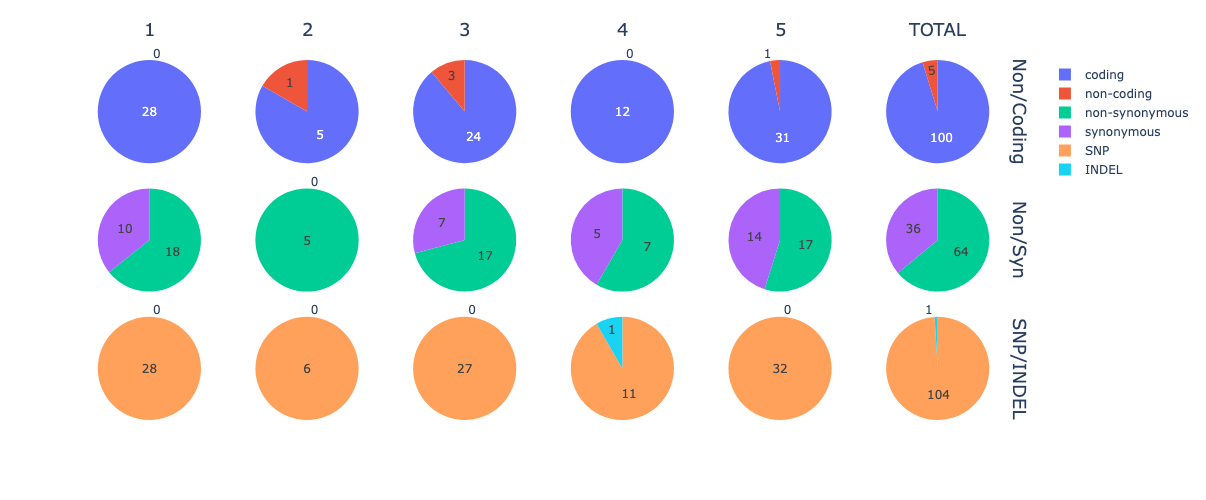

In [52]:
fig = px.pie(mut_counts_df, names='annotation', values='count', facet_col='Cluster_Assignment', facet_row='type', height=500, facet_row_spacing=0.07)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Cluster_Assignment=", ""), y=1.05), selector={'xanchor': 'center'})
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("type=", "")))
fig.for_each_annotation(lambda a: a.update(font_size=18))
fig.update_traces(textinfo='value')

In [54]:
mut_counts_df

,non-coding,non-synonymous,synonymous,coding,INDEL,SNP
Cluster_Assignment,,,,,,
1,0,18,10,28,0,28
2,1,5,0,5,0,6
3,3,17,7,24,0,27
4,0,7,5,12,1,11
5,1,17,14,31,0,32


In [61]:
mut_counts_df['non-coding'].drop(5).sum()

4

In [66]:
df = pd.DataFrame()
for col1, col2 in zip(['non-coding', 'synonymous', 'INDEL'], ['coding', 'non-synonymous','SNP']):
    for idx in mut_counts_df.index:
        df.loc[idx, col2] = get_fisher_exact(mut_counts_df, idx, col1, col2)

In [65]:
import scipy.stats as ss
def get_fisher_exact(df, idx, col1, col2):
    odds_ratio, p_val = ss.fisher_exact([[df.loc[idx, col1], df[col1].drop(idx).sum()],
                                         [df.loc[idx, col2], df[col2].drop(idx).sum()]])
    return p_val

In [67]:
df

,coding,non-synonymous,SNP
1,0.321231,1.000000,1.000000
2,0.259293,0.156353,1.000000
3,0.105979,0.473966,1.000000
4,1.000000,0.751792,0.114286
5,1.000000,0.260635,1.000000


In [71]:
test = (df < 0.15).any(axis=1)
